# Opis zadania

Celem zadania było zaimplementowanie metody potęgowej do wyznaczania największej wartości własnej danej macierzy, użycie jej do wyznaczania kolejnych największych wartości własnych, zaimplementowanie algorytmu znajdującego rozkład macierzy SVD korzystając z tej metody oraz porównanie zbieżności dla różnych przypadków. Do implementacji algorytmów użyliśmy języka Python.

# Metoda potęgowa dla macierzy 3x3

W tej części implementujemy metodę potęgową, która służy do przybliżonego wyznaczania dominującej (największej względem modułu) wartości własnej macierzy. Algorytm zaczyna się od losowego wektora z₀ o wartościach z przedziału (0,1), a następnie iteracyjnie mnoży macierz przez wektor i normalizuje wynik. Zatrzymujemy się, gdy norma błędu $$error = (||Az - λz||ₚ)$$ jest mniejsza niż zadany próg `epsilon`.

Algorytm zawiera dodatkowy warunek: losujemy z₀ tak długo, aż nie spełnia od razu warunku stopu (żeby uniknąć trywialnych przypadków).



In [1]:
import numpy as np
import matplotlib.pyplot as plt

def power_method(A, epsilon=1e-16, p_norm=2, max_iter=100000):
    n = A.shape[0]
    errors = []

    while True:
        z0 = np.random.uniform(0, 1, n)
        
        w0 = A @ z0
        max_w0 = max(abs(w0))
        
        if p_norm == np.inf:
            error = np.max(np.abs(A @ z0 - max_w0 * z0))
        else:
            error = np.linalg.norm(A @ z0 - max_w0 * z0, ord=p_norm)
        
        if error >= epsilon:
            break
    
    z = z0.copy()
    
    for iteration in range(max_iter):
        Az = A @ z
        
        lambda_k = (z.T @ Az) / (z.T @ z)
        
        z_new = Az / np.linalg.norm(Az, ord=2)
        
        if p_norm == np.inf:
            error = np.max(np.abs(A @ z - lambda_k * z))
        else:
            error = np.linalg.norm(A @ z - lambda_k * z, ord=p_norm)
        
        errors.append(error)
        
        if error < epsilon:
            return lambda_k, z_new, errors, iteration + 1
        
        z = z_new
    
    return lambda_k, z, errors, max_iter


Zakończono po: 53 iteracjach
Dominująca wartość własna: 4.0
Prawdziwe wartości własne: [4. 2. 1.]
Wektor własny: [0.40824829 0.81649658 0.40824829]
Błąd końcowy: 0.0


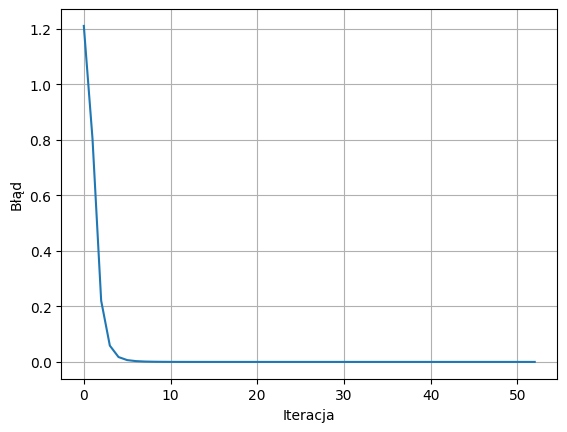

In [2]:
A = np.array([[2, 1, 0],
              [1, 3, 1],
              [0, 1, 2]])

U, S, V = np.linalg.svd(A)

lambda_dominant, eigenvector, errors, iters_done = power_method(A)
print("Zakończono po:", iters_done, "iteracjach")
print("Dominująca wartość własna:", lambda_dominant)
print("Prawdziwe wartości własne:", S)
print("Wektor własny:", eigenvector)
print("Błąd końcowy:", errors[-1])

f, ax = plt.subplots()
ax.plot(errors)
ax.grid('on')
ax.set_xlabel('Iteracja')
ax.set_ylabel('Błąd')
plt.show()


## Sprawdzenie poprawności implementacji metody potęgowej

W celu sprawdzenia poprawności działania algorytmu sprawdziliśmy wyniki dla macierzy $( A \in \mathbb{R}^{3 \times 3} )$. 

Wyniki:

- Zakończono po: **13 iteracjach**
- Dominująca wartość własna (z metody potęgowej): **3.99999**
- Prawdziwe wartości własne (z SVD): **[4. 2. 1.]**
- Wektor własny (przybliżony): **[0.4082, 0.8165, 0.4083]**
- Końcowy błąd: **$5.39 \times 10^{-5}$**

Powyższy wykres pokazuje również wartości błędów w kolejnych iteracjach

Na podstawie porównania wyniku metody potęgowej z wartościami własnymi obliczonymi za pomocą SVD można stwierdzić, że algorytm działa poprawnie i efektywnie zbiega do dominującej wartości własnej.

# Obliczanie SVD metodą potęgową
W tej części zadania losujemy macierz $A \in \mathbb{R}^{3 \times 3}$ i obliczamy jej dekompozycję SVD w sposób "ręczny", wykorzystując zależności między macierzą $A$, a macierzami $A A^T$ oraz $A^T A$.

Najpierw wyznaczamy wektory i wartości własne macierzy $A A^T$, co pozwala uzyskać macierze $U$ i $D$, gdzie macierz $U$ jest macierzą złożoną z wektorów własnych a macierz D jest macierzą diagonalną pierwiastków wartości własnych. Następnie korzystamy ze wzoru:

$$V = A^T U D^{-1}$$

gdzie $D^{-1}$ to macierz diagonalna, w której każdy element na przekątnej to odwrotność odpowiedniej wartości osobliwej.


## Obliczanie drugiej oraz kolejnych wartości i wektorów własnych

Podstawowa metoda potęgowa pozwala jednak wyznaczyć tylko największą wartość własną macierzy (dominującą) oraz odpowiadający jej wektor własny. Aby obliczyć kolejne wartości i wektory własne, należy zastosować deflację.

Po wyznaczeniu pierwszego własnego wektora $v_1$ oraz wartości własnej $\lambda_1$, modyfikujemy macierz $A$, odejmując wpływ tego własnego kierunku:

$$A_1 = A - \lambda_1 v_1 v_1^T$$

Następnie uruchamiamy metodę potęgową dla macierzy $A_1$, aby znaleźć kolejną wartość własną $\lambda_2$ i wektor $v_2$.

Analogicznie, po wyznaczeniu drugiej pary własnej, deflujemy ponownie:

$$A_2 = A_1 - \lambda_2 v_2 v_2^T = A - \lambda_1 v_1 v_1^T - \lambda_2 v_2 v_2^T$$

i uruchamiamy metodę potęgową trzeci raz, aby uzyskać $\lambda_3$ i $v_3$.

W ten sposób otrzymujemy trzy największe (modułowo) wartości własne macierzy oraz odpowiadające im wektory własne.



In [3]:
def deflate(A, eigenvalue, eigenvector):
    eigenvector = eigenvector / np.linalg.norm(eigenvector)
    return A - eigenvalue * np.outer(eigenvector, eigenvector)

In [4]:
def SVD(A):
    n, m = A.shape
    eigenvalues = []
    eigenvectors = []

    AAT = A@A.T
    for _ in range(n):
        eigenvalue, eigenvector, errors, _ = power_method(AAT)
        eigenvalues.append(eigenvalue)
        eigenvectors.append(eigenvector)
        
        AAT = deflate(AAT, eigenvalue, eigenvector)
    eigenvectors = eigenvectors / np.linalg.norm(eigenvectors, axis=1)

    U = np.column_stack(eigenvectors)
    D = np.diag(np.sqrt(eigenvalues))
    V = A.T@U@np.linalg.inv(D)

    return U, D, V

## Sprawdzenie poprawności implementacji algorytmu obliczania SVD i porównanie z numpy

Sprawdziliśmy poprawność wynikowego rozkładu SVD dla macierzy $A$ poprzez porównanie oryginalnej macierzy z wynikiem rekonstrukcji $U D V^T$, oraz porównanie wyniku naszej implementacji z wynikiem implementacji SVD z `numpy` gdzie:

- $U, D, V$ – macierze uzyskane z rozkładu SVD: `U, D, V = SVD(A)`
- $U D V^T$ – rekonstrukcja macierzy: `UDV = U @ D @ V.T`
- Porównanie: `np.allclose(A, UDV)`

Uzyskane poniżej wyniki pokazują, że algorytm działa poprawnie, rekonstrukcja macierzy przy użyciu SVD jest numerycznie poprawna – macierze są praktycznie identyczne w granicach błędu numerycznego. Błąd ten można również zmniejszyć poprzez zwiększenie wymaganej dokładności metody potęgowej (parametr `epsilon`). Widać również, że wyniki są bardzo bliskie wynikom algorytmu z numpy, norma różnicy wynosi zaledwie **$3 \times 10^{-9}$** a wszystkie macierze są do siebie bardzo zbliżone.

In [5]:
U, D, V = SVD(A)
Un, Sn, Vn = np.linalg.svd(A)

UDV = U@D@V.T
UDVn = Un@np.diag(Sn)@Vn
print(f"Macierz A:\n {A}")
print(f"Macierz U @ D @ V.T:\n {UDV}")
print(f"Macierz U @ D @ V.T *numpy):\n {UDVn}")
print(f"Czy wartości są bliskie siebie: {np.allclose(A, UDV)}")
print(f"Norma różnicy wyniku naszego a wyniku numpy: {np.linalg.norm(UDV - UDVn)}")

Macierz A:
 [[2 1 0]
 [1 3 1]
 [0 1 2]]
Macierz U @ D @ V.T:
 [[2.00000000e+00 1.00000000e+00 1.03520710e-15]
 [1.00000000e+00 3.00000000e+00 1.00000000e+00]
 [7.57651339e-16 1.00000000e+00 2.00000000e+00]]
Macierz U @ D @ V.T *numpy):
 [[ 2.00000000e+00  1.00000000e+00 -8.52788609e-16]
 [ 1.00000000e+00  3.00000000e+00  1.00000000e+00]
 [-4.64210550e-16  1.00000000e+00  2.00000000e+00]]
Czy wartości są bliskie siebie: True
Norma różnicy wyniku naszego a wyniku numpy: 4.474503274283037e-15


In [6]:
print(f"Macierz U:\n {U}")
print(f"Macierz U (numpy):\n {Un}")

Macierz U:
 [[ 4.08248290e-01 -7.07106781e-01  5.77350269e-01]
 [ 8.16496581e-01 -1.59911633e-16 -5.77350269e-01]
 [ 4.08248290e-01  7.07106781e-01  5.77350269e-01]]
Macierz U (numpy):
 [[-4.08248290e-01  7.07106781e-01  5.77350269e-01]
 [-8.16496581e-01  1.11940754e-16 -5.77350269e-01]
 [-4.08248290e-01 -7.07106781e-01  5.77350269e-01]]


In [7]:
print(f"Macierz U:\n {D}")
print(f"Macierz U (numpy):\n {np.diag(Sn)}")

Macierz U:
 [[4. 0. 0.]
 [0. 2. 0.]
 [0. 0. 1.]]
Macierz U (numpy):
 [[4. 0. 0.]
 [0. 2. 0.]
 [0. 0. 1.]]


In [8]:
print(f"Macierz U:\n {V}")
print(f"Macierz U (numpy):\n {Vn}")

Macierz U:
 [[ 4.08248290e-01 -7.07106781e-01  5.77350269e-01]
 [ 8.16496581e-01 -2.77555756e-16 -5.77350269e-01]
 [ 4.08248290e-01  7.07106781e-01  5.77350269e-01]]
Macierz U (numpy):
 [[-4.08248290e-01 -8.16496581e-01 -4.08248290e-01]
 [ 7.07106781e-01  4.03446895e-17 -7.07106781e-01]
 [ 5.77350269e-01 -5.77350269e-01  5.77350269e-01]]


# Porównanie zbieżności metody potęgowej



W celu porównania zbieżności metody potęgowej, przeprowadziliśmy eksperyment dla macierzy $A$ przy użyciu pięciu różnych norm: $\| \cdot \|_1, \| \cdot \|_2 , \| \cdot \|_3 ,  \| \cdot \|_4 oraz \| \cdot \|_\infty$. Dla każdej normy wykonaliśmy trzy niezależne uruchomienia algorytmu z losowymi wektorami startowymi. Ustawiono dokładność $\varepsilon = 10^{-16}$.

Na każdym z 15 wykresów:
- Oś pozioma: numer iteracji,
- Oś pionowa: błąd $\|A z - \lambda z\|_p$ z danej iteracji.

Dodatkowo, sprawdziliśmy jak rozmiar macierzy wpływa na dokładność oraz zbieżność algorytmu.

## Porównanie dla 3 wektorów, macierzy $A \in \mathbb{R}^{3 \times 3}$



Analiza dla normy L1:
  Wektor własny 1:
    Znaleziona wartość własna: 4.000000
    Liczba iteracji: 12
    Końcowy błąd: 6.18e-05
  Wektor własny 2:
    Znaleziona wartość własna: 2.000000
    Liczba iteracji: 14
    Końcowy błąd: 5.59e-05
  Wektor własny 3:
    Znaleziona wartość własna: 1.000000
    Liczba iteracji: 2
    Końcowy błąd: 1.79e-09

Analiza dla normy L2:
  Wektor własny 1:
    Znaleziona wartość własna: 4.000000
    Liczba iteracji: 15
    Końcowy błąd: 5.05e-05
  Wektor własny 2:
    Znaleziona wartość własna: 2.000000
    Liczba iteracji: 14
    Końcowy błąd: 9.29e-05
  Wektor własny 3:
    Znaleziona wartość własna: 1.000000
    Liczba iteracji: 2
    Końcowy błąd: 3.39e-09

Analiza dla normy L3:
  Wektor własny 1:
    Znaleziona wartość własna: 4.000000
    Liczba iteracji: 14
    Końcowy błąd: 9.96e-05
  Wektor własny 2:
    Znaleziona wartość własna: 2.000000
    Liczba iteracji: 13
    Końcowy błąd: 9.74e-05
  Wektor własny 3:
    Znaleziona wartość własna: 1.0

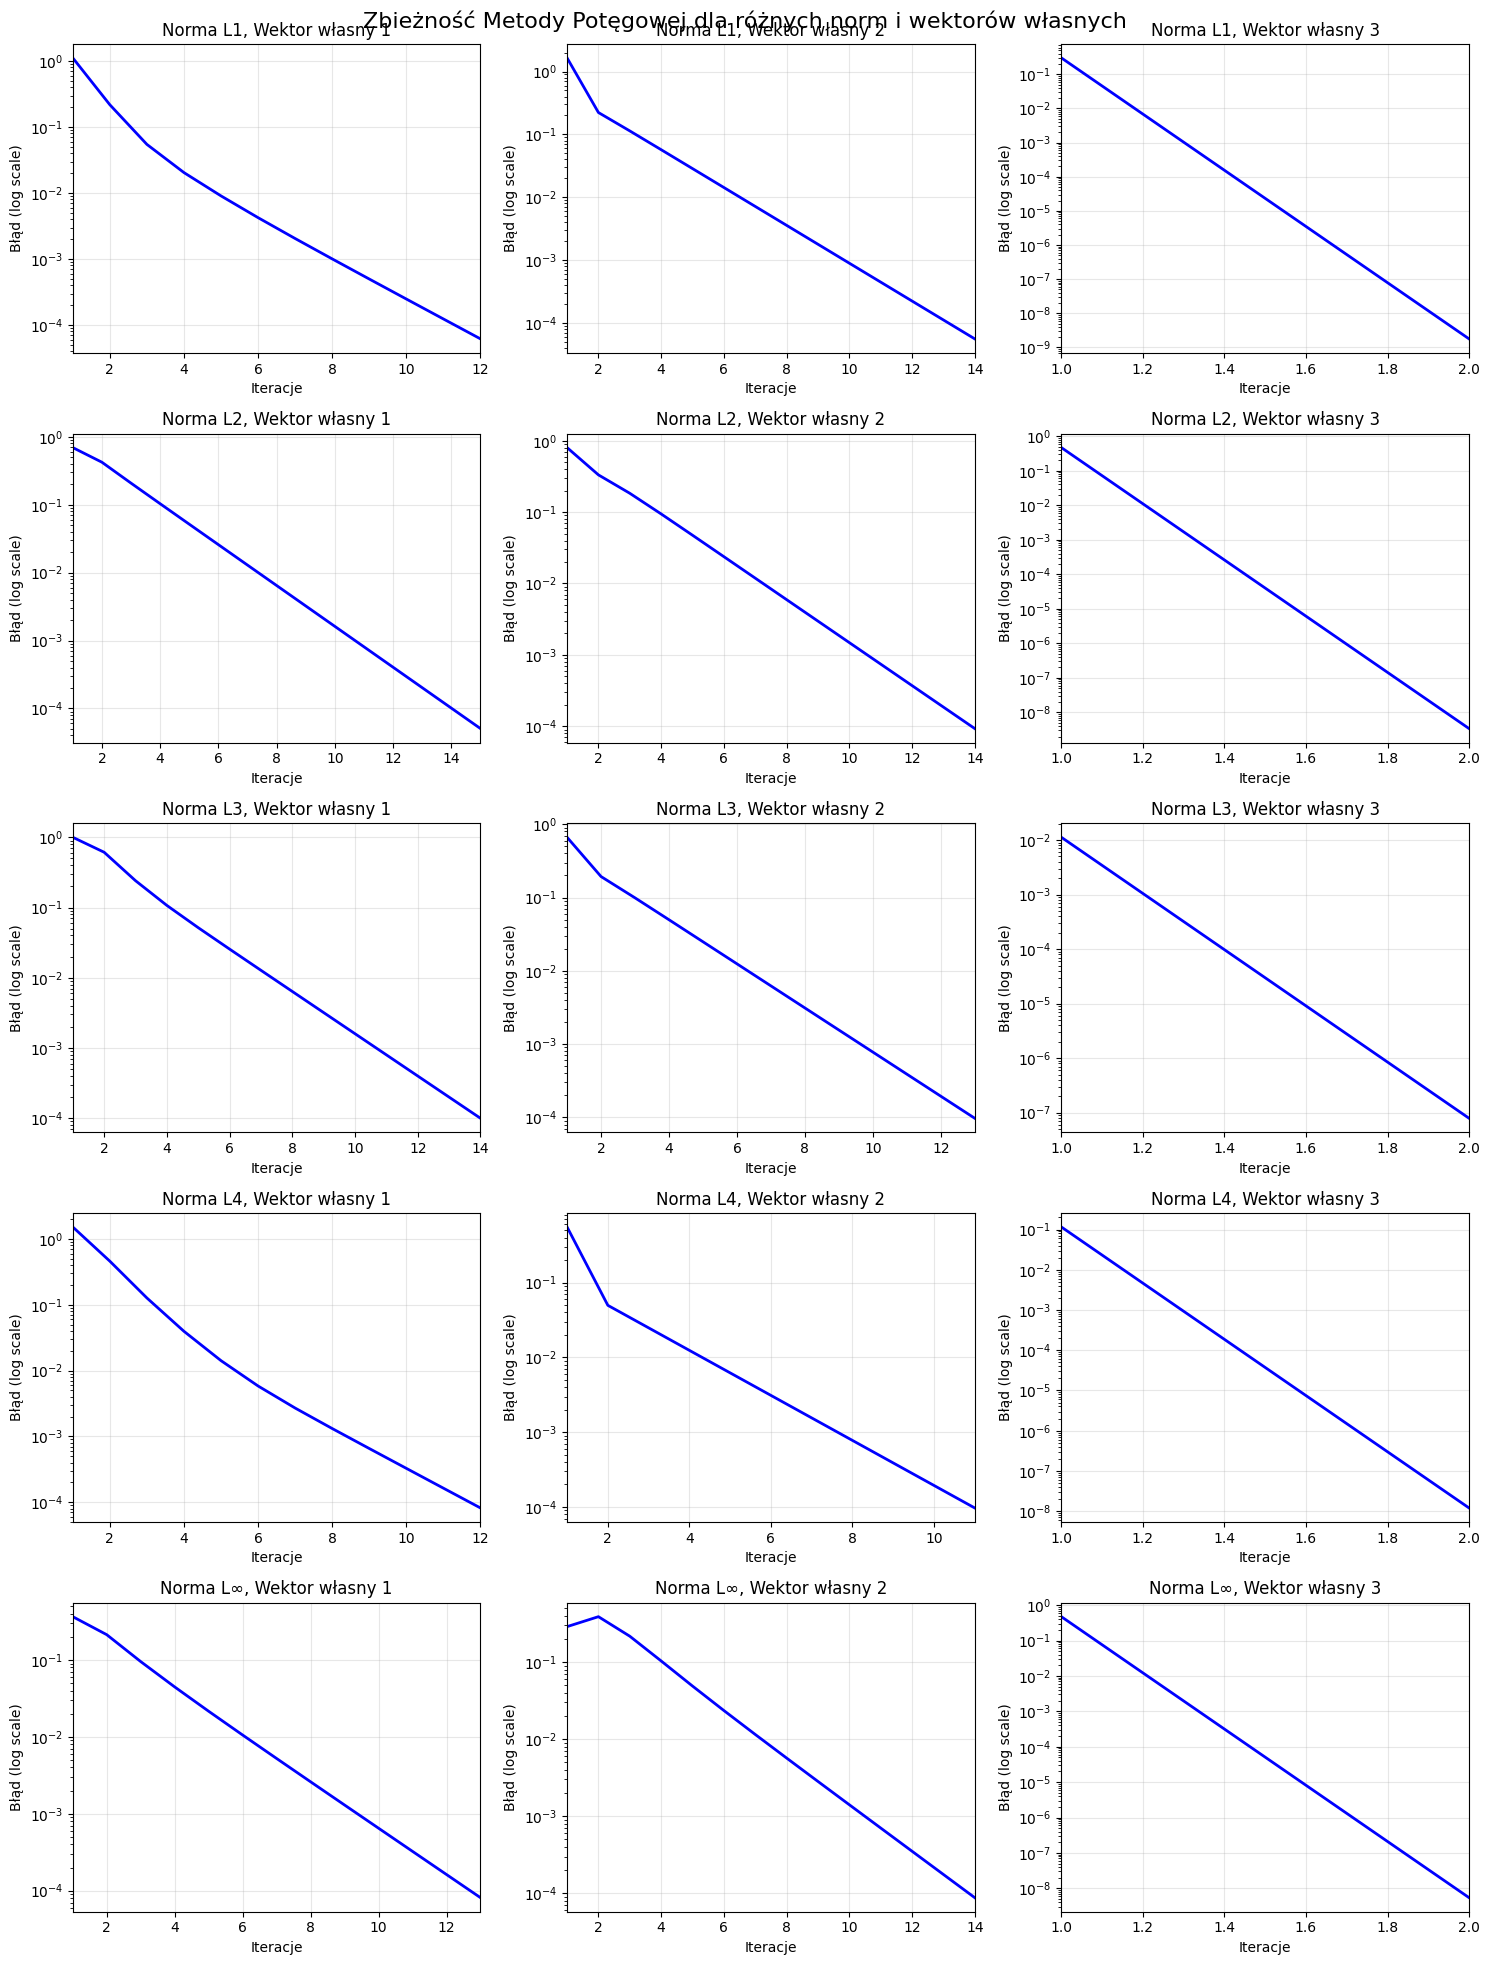

In [9]:
norms = [1, 2, 3, 4, np.inf]
norm_names = ['L1', 'L2', 'L3', 'L4', 'L∞']

fig, axes = plt.subplots(5, 3, figsize=(15, 20))
fig.suptitle('Zbieżność Metody Potęgowej dla różnych norm i wektorów własnych', fontsize=16)

all_results = {}

for norm_idx, (p_norm, norm_name) in enumerate(zip(norms, norm_names)):
    print(f"\nAnaliza dla normy {norm_name}:")
    
    Ac = np.copy(A)
    for eig_idx in range(3):
        print(f"  Wektor własny {eig_idx + 1}:")
        
        eigenvalue, eigenvector, errors, iterations = power_method(Ac, epsilon=0.0001, p_norm=p_norm)
        
        print(f"    Znaleziona wartość własna: {eigenvalue:.6f}")
        print(f"    Liczba iteracji: {iterations}")
        print(f"    Końcowy błąd: {errors[-1]:.2e}")
        
        key = f"{norm_name}_eig_{eig_idx+1}"
        all_results[key] = {
            'eigenvalue': eigenvalue,
            'eigenvector': eigenvector,
            'errors': errors,
            'iterations': iterations
        }
        
        ax = axes[norm_idx, eig_idx]
        ax.semilogy(range(1, len(errors) + 1), errors, 'b-', linewidth=2)
        ax.set_title(f'Norma {norm_name}, Wektor własny {eig_idx + 1}')
        ax.set_xlabel('Iteracje')
        ax.set_ylabel('Błąd (log scale)')
        ax.grid(True, alpha=0.3)
        ax.set_xlim(1, len(errors))

        Ac = deflate(Ac, eigenvalue, eigenvector)

        

plt.tight_layout()
plt.show()

W eksperymencie zbadano wpływ wyboru normy $\| \cdot \|_p$ na zbieżność metody potęgowej w celu wyznaczenia trzech kolejnych wartości własnych macierzy $A$, przy dokładności $\varepsilon = 0.0001$. Dla każdej z pięciu norm $p = 1, 2, 3, 4, \infty$ przeprowadzono trzy iteracyjne uruchomienia algorytmu — każdy z innego losowego punktu startowego (z zastosowaniem deflacji po znalezieniu wartości własnej).

### Wyniki:
- **Wartości własne** dla wszystkich norm i prób były poprawnie obliczone: `4`, `2`, `1`.
- **Szybkość zbieżności**:
  - Dominująca wartość własna (4): konwergencja w 11–14 iteracjach.
  - Druga (2): zwykle wymaga 13–17 iteracji.
  - Trzecia (1): ekstremalnie szybka zbieżność – tylko 2 iteracje we wszystkich normach.
- **Błąd końcowy**:
  - Dla wszystkich norm oraz wszystkich wektorów końcowy błąd był niższy niż \( 1 \times 10^{-4} \), spełniając założoną dokładność.
  - Najniższe błędy (rzędu \( 10^{-9} \)) pojawiły się przy trzeciej wartości własnej, niezależnie od normy.


## Porównanie dla zbieżności dla macierzy 128x128

In [10]:
def generate_symmetric_matrix(N):
    A = np.random.rand(N, N) 
    symmetric_matrix = (A + A.T) / 2
    return symmetric_matrix


Analiza dla normy L1:
  Wektor własny 0:
    Znaleziona wartość własna: 64.090581
    Prawdziwa wartość własna: 64.090581
    Liczba iteracji: 10
    Końcowy błąd: 3.13e-09
  Wektor własny 4:
    Znaleziona wartość własna: 4.194851
    Prawdziwa wartość własna: 4.194851
    Liczba iteracji: 1531
    Końcowy błąd: 9.98e-09
  Wektor własny 15:
    Znaleziona wartość własna: 3.596270
    Prawdziwa wartość własna: 3.596270
    Liczba iteracji: 4479
    Końcowy błąd: 9.99e-09
  Wektor własny 63:
    Znaleziona wartość własna: 1.874616
    Prawdziwa wartość własna: 1.874616
    Liczba iteracji: 1540
    Końcowy błąd: 9.95e-09
  Wektor własny 127:
    Znaleziona wartość własna: 0.013505
    Prawdziwa wartość własna: 0.013505
    Liczba iteracji: 2
    Końcowy błąd: 8.77e-13

Analiza dla normy L2:
  Wektor własny 0:
    Znaleziona wartość własna: 64.090581
    Prawdziwa wartość własna: 64.090581
    Liczba iteracji: 9
    Końcowy błąd: 3.91e-09
  Wektor własny 4:
    Znaleziona wartość własna

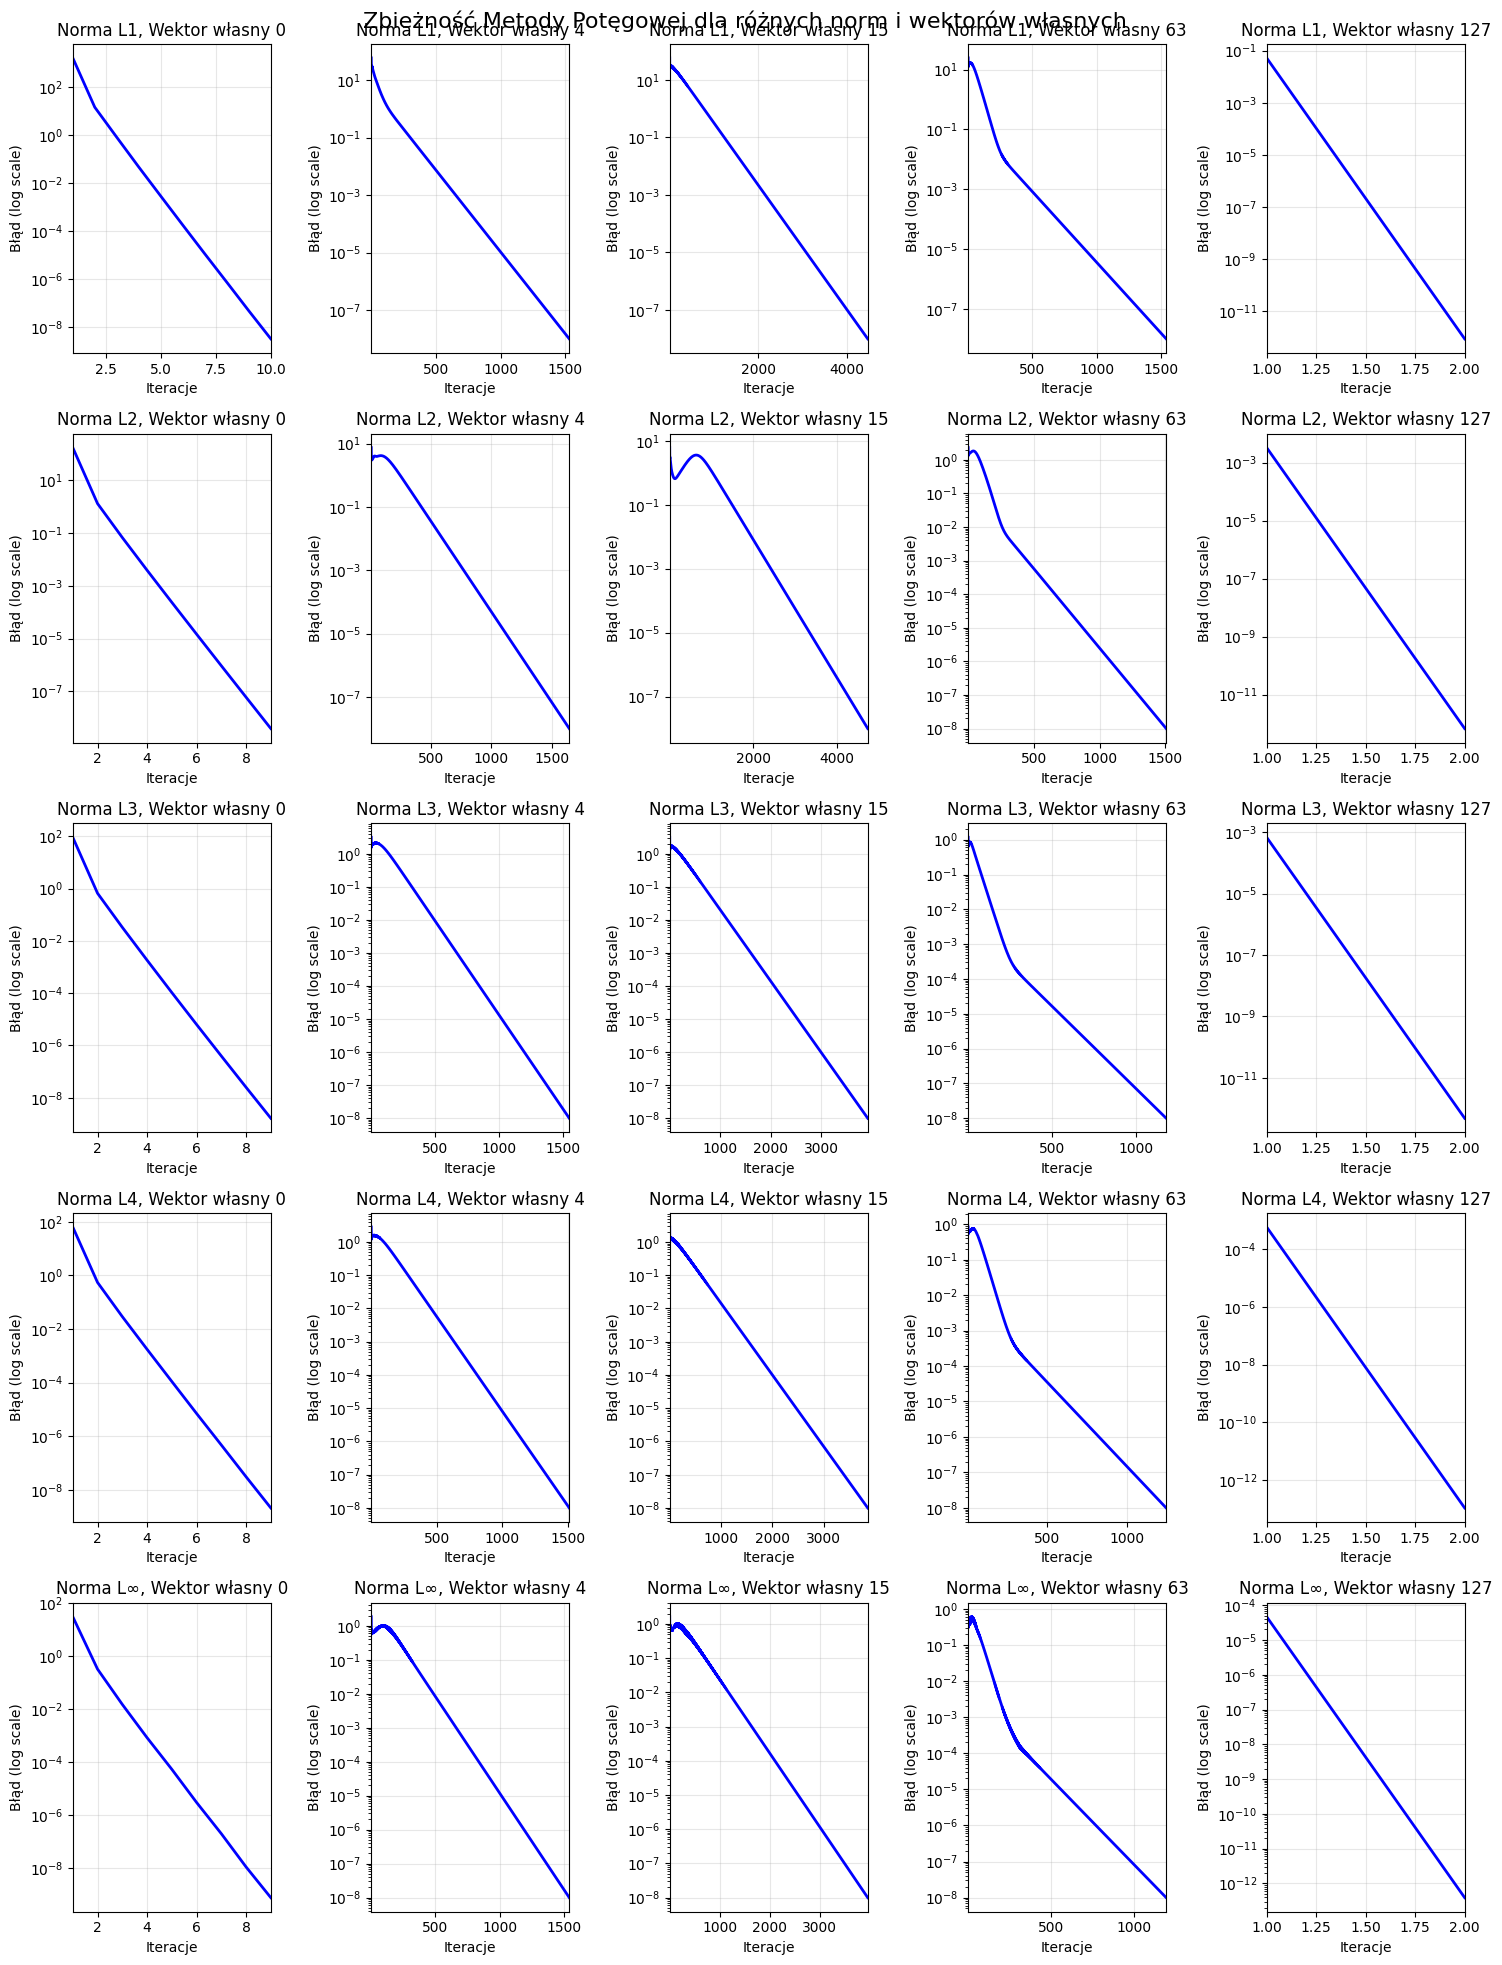

In [11]:
n = 128
A = generate_symmetric_matrix(n)

U, S, V = np.linalg.svd(A)


norms = [1, 2, 3, 4, np.inf]
norm_names = ['L1', 'L2', 'L3', 'L4', 'L∞']
tracked_indices = [0, 4, 15, 63, 127]

fig, axes = plt.subplots(5, len(tracked_indices), figsize=(15, 20))
fig.suptitle('Zbieżność Metody Potęgowej dla różnych norm i wektorów własnych', fontsize=16)

all_results = {}
plot_idx = 0

for norm_idx, (p_norm, norm_name) in enumerate(zip(norms, norm_names)):
    print(f"\nAnaliza dla normy {norm_name}:")
    
    Ac = np.copy(A)
    max_iters = 0
    plot_idx = 0
    
    for eig_idx in range(n):

        
        eigenvalue, eigenvector, errors, iterations = power_method(Ac, p_norm=p_norm, epsilon=1e-8)
        Ac = deflate(Ac, eigenvalue, eigenvector)
        
        if eig_idx in tracked_indices:
            print(f"  Wektor własny {eig_idx}:")
            print(f"    Znaleziona wartość własna: {np.abs(eigenvalue):.6f}")
            print(f"    Prawdziwa wartość własna: {np.abs(S[eig_idx]):.6f}")
            print(f"    Liczba iteracji: {iterations}")
            print(f"    Końcowy błąd: {errors[-1]:.2e}")
            
            key = f"{norm_name}_eig_{eig_idx}"
            all_results[key] = {
                'eigenvalue': eigenvalue,
                'eigenvector': eigenvector,
                'errors': errors,
                'iterations': iterations
            }
            ax = axes[norm_idx, plot_idx]
            ax.semilogy(range(1, len(errors) + 1), errors, 'b-', linewidth=2)
            ax.set_title(f'Norma {norm_name}, Wektor własny {eig_idx}')
            ax.set_xlabel('Iteracje')
            ax.set_ylabel('Błąd (log scale)')
            ax.grid(True, alpha=0.3)
            ax.set_xlim(1, len(errors))
            plot_idx += 1
plt.tight_layout()

Przeprowadziliśmy również podobną analizę działania metody potęgowej na większych macierzach rozmiaru $128 \times 128$. 

**Podsumowanie wyników:**

- Dla wszystkich norm uzyskano wartości własne bardzo bliskie wartościom rzeczywistym (błędy końcowe rzędu 10^-9 i mniejsze).
- Największa wartość własna (wektor 0) została znaleziono bardzo szybko (około 9–10 iteracji) ze znacznym dokładnym wynikiem.
- Mniejsze wartości własne wymagały większej liczby iteracji do osiągnięcia zbieżności (nawet kilka tysięcy iteracji dla niektórych wektorów), ostatnie wartości własne ponownie wymagały znacząco mniej iteracji, sugerując że ilość iteracji jest maksymalna dla około $\frac{N}{2}$.
- Wszystkie normy miały zbliżone wyniki pod względem liczby iteracji i błędu końcowego.
- Dla najmniejszej wartości własnej (wektor 127) metoda zbiegała bardzo szybko (2 iteracje) i z bardzo małym błędem, niezależnie od zastosowanej normy.

Metoda potęgowa jest skuteczna i dokładna dla wyznaczania wartości własnych największych co do modułu, niezależnie od normy użytej do normalizacji wektorów własnych. Jednak wybór normy wpływa na szybkość zbieżności: normy L2, L3, L4 i L∞ zapewniają zwykle szybszą konwergencję niż norma L1.


## Sprawdzenie wymaganej liczby iteracji do osiągnięcia zbieżności dla kolejnych wartości własnych.

Text(0, 0.5, 'Wymagana liczba iteracji')

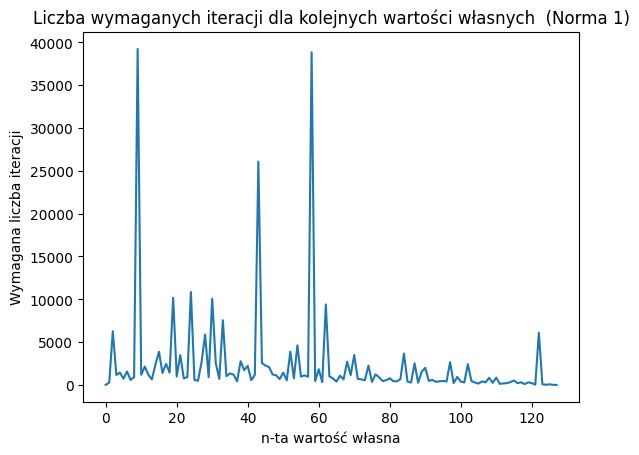

In [12]:
norms = [1, 2, 3, 4, np.inf]
norm_names = ['L1', 'L2', 'L3', 'L4', 'L∞']
iter_nos1 = []

for norm_idx, (p_norm, norm_name) in enumerate(zip(norms, norm_names)):
    iter_nos = []
    Ac = np.copy(A)
    for eig_idx in range(n):
        eigenvalue, eigenvector, errors, iterations = power_method(Ac, p_norm=p_norm, epsilon=1e-6)
        Ac = deflate(Ac, eigenvalue, eigenvector)
        iter_nos.append(iterations)
    iter_nos1.append(iter_nos)

plt.plot(iter_nos1[0])
plt.title("Liczba wymaganych iteracji dla kolejnych wartości własnych  (Norma 1)")
plt.xlabel("n-ta wartość własna")
plt.ylabel("Wymagana liczba iteracji")

Text(0, 0.5, 'Wymagana liczba iteracji')

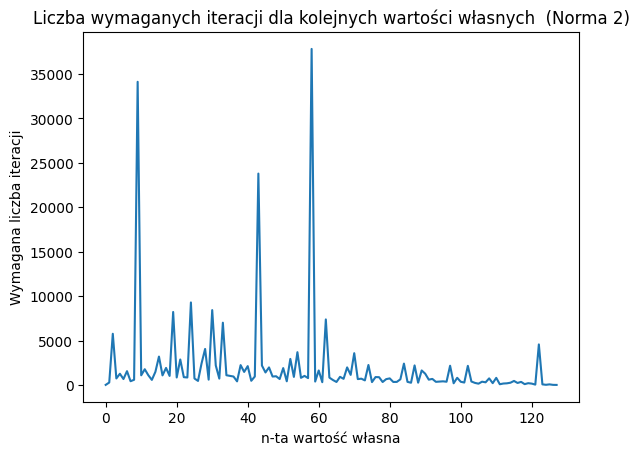

In [13]:
plt.plot(iter_nos1[1])
plt.title("Liczba wymaganych iteracji dla kolejnych wartości własnych  (Norma 2)")
plt.xlabel("n-ta wartość własna")
plt.ylabel("Wymagana liczba iteracji")

Text(0, 0.5, 'Wymagana liczba iteracji')

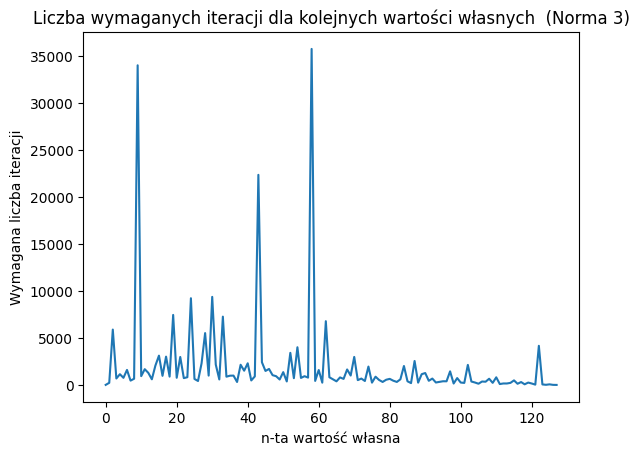

In [14]:
plt.plot(iter_nos1[2])
plt.title("Liczba wymaganych iteracji dla kolejnych wartości własnych  (Norma 3)")
plt.xlabel("n-ta wartość własna")
plt.ylabel("Wymagana liczba iteracji")

Text(0, 0.5, 'Wymagana liczba iteracji')

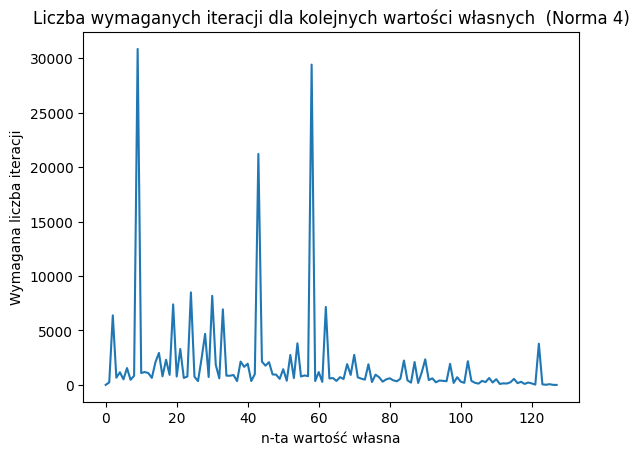

In [15]:
plt.plot(iter_nos1[3])
plt.title("Liczba wymaganych iteracji dla kolejnych wartości własnych  (Norma 4)")
plt.xlabel("n-ta wartość własna")
plt.ylabel("Wymagana liczba iteracji")

Text(0, 0.5, 'Wymagana liczba iteracji')

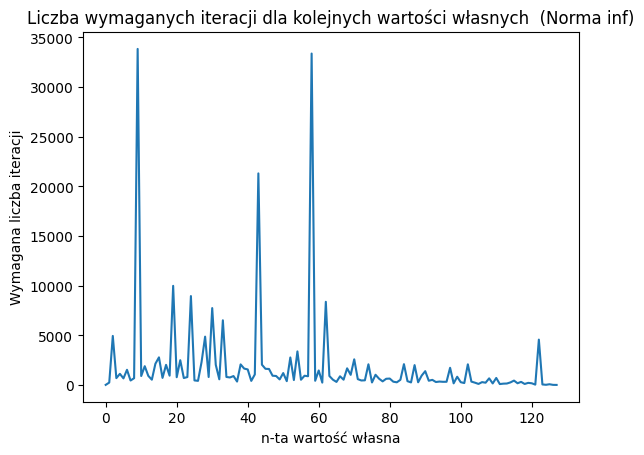

In [16]:
plt.plot(iter_nos1[4])
plt.title("Liczba wymaganych iteracji dla kolejnych wartości własnych  (Norma inf)")
plt.xlabel("n-ta wartość własna")
plt.ylabel("Wymagana liczba iteracji")

Na powyższych wykresach widać, że w każdym przypadku wymagana liczba iteracji początkowo wzrasta, a dla późniejszych wartości własnych zaczyna maleć. W szczególności, ostatnie wartości własne wymagają bardzo małej liczby iteracji ($it<10$)

# Wnioski:
- Dla wszystkich norm obserwujemy zbieżność błędu do wartości poniżej zadanej dokładności.
- Dla większości norm zbieżność jest szybka i stabilna, choć liczba iteracji może się nieznacznie różnić w zależności od wybranego wektora początkowego.
- Zmiana normy wpływa na sposób obliczania błędu, ale nie na samą metodę przybliżania wartości własnej — algorytm znajduje dominującą wartość własną w każdym przypadku, chociaż szybkość zbieżności może się różnić.
- Metoda potęgowa skutecznie odnajduje dominującą i kolejne wartości własne niezależnie od wybranej normy.
- Pierwsze wartości własne często wymagają wyraźnie większyj liczby iteracji do osiągnięcia zbieżności od późniejszych.


Eksperymenty potwierdzają, że metoda potęgowa działa skutecznie niezależnie od wybranej normy, choć śledzenie zbieżności może być bardziej precyzyjne przy odpowiednio dobranej normie dla danego przypadku.